In [1]:
#!pip install tabulate

In [2]:
import os
import csv
import sys
import re

from surprise import Dataset
from surprise import Reader

from collections import defaultdict
import numpy as np
import pandas as pd
from tabulate import tabulate

class MovieLens:

    movieID_to_name = {}
    name_to_movieID = {}
    ratingsPath = '/Users/Z0094BV/Downloads/RecSys-Materials/ml-latest-small/ratings.csv'
    moviesPath = '/Users/Z0094BV/Downloads/RecSys-Materials/ml-latest-small/movies.csv'
    
    def loadMovieLensLatestSmall(self):

        # Look for files relative to the directory we are running from
        os.chdir(os.path.dirname(sys.argv[0]))

        ratingsDataset = 0
        self.movieID_to_name = {}
        self.name_to_movieID = {}

        reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)

        ratingsDataset = Dataset.load_from_file(self.ratingsPath, reader=reader)

        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
                movieReader = csv.reader(csvfile)
                next(movieReader)  #Skip header line
                for row in movieReader:
                    movieID = int(row[0])
                    movieName = row[1]
                    self.movieID_to_name[movieID] = movieName
                    self.name_to_movieID[movieName] = movieID

        return ratingsDataset

    def getUserRatings(self, user):
        userRatings = []
        hitUser = False
        with open(self.ratingsPath, newline='') as csvfile:
            ratingReader = csv.reader(csvfile)
            next(ratingReader)
            for row in ratingReader:
                userID = int(row[0])
                if (user == userID):
                    movieID = int(row[1])
                    rating = float(row[2])
                    userRatings.append((movieID, rating))
                    hitUser = True
                if (hitUser and (user != userID)):
                    break

        return userRatings

    def getPopularityRanks(self):
        ratings = defaultdict(int)
        rankings = defaultdict(int)
        with open(self.ratingsPath, newline='') as csvfile:
            ratingReader = csv.reader(csvfile)
            next(ratingReader)
            for row in ratingReader:
                movieID = int(row[1])
                ratings[movieID] += 1
        rank = 1
        for movieID, ratingCount in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
            rankings[movieID] = rank
            rank += 1
        return rankings
    
    def getGenres(self):
        genres = defaultdict(list)
        genreIDs = {}
        maxGenreID = 0
        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
            movieReader = csv.reader(csvfile)
            next(movieReader)  #Skip header line
            for row in movieReader:
                movieID = int(row[0])
                genreList = row[2].split('|')
                genreIDList = []
                for genre in genreList:
                    if genre in genreIDs:
                        genreID = genreIDs[genre]
                    else:
                        genreID = maxGenreID
                        genreIDs[genre] = genreID
                        maxGenreID += 1
                    genreIDList.append(genreID)
                genres[movieID] = genreIDList
        # Convert integer-encoded genre lists to bitfields that we can treat as vectors
        for (movieID, genreIDList) in genres.items():
            bitfield = [0] * maxGenreID
            for genreID in genreIDList:
                bitfield[genreID] = 1
            genres[movieID] = bitfield            
        
        return genres
    
    def getYears(self):
        p = re.compile(r"(?:\((\d{4})\))?\s*$")
        years = defaultdict(int)
        with open(self.moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
            movieReader = csv.reader(csvfile)
            next(movieReader)
            for row in movieReader:
                movieID = int(row[0])
                title = row[1]
                m = p.search(title)
                year = m.group(1)
                if year:
                    years[movieID] = int(year)
        return years
    
    def getMiseEnScene(self):
        mes = defaultdict(list)
        with open("LLVisualFeatures13K_Log.csv", newline='') as csvfile:
            mesReader = csv.reader(csvfile)
            next(mesReader)
            for row in mesReader:
                movieID = int(row[0])
                avgShotLength = float(row[1])
                meanColorVariance = float(row[2])
                stddevColorVariance = float(row[3])
                meanMotion = float(row[4])
                stddevMotion = float(row[5])
                meanLightingKey = float(row[6])
                numShots = float(row[7])
                mes[movieID] = [avgShotLength, meanColorVariance, stddevColorVariance,
                   meanMotion, stddevMotion, meanLightingKey, numShots]
        return mes
    
    def getMovieName(self, movieID):
        if movieID in self.movieID_to_name:
            return self.movieID_to_name[movieID]
        else:
            return ""
        
    def getMovieID(self, movieName):
        if movieName in self.name_to_movieID:
            return self.name_to_movieID[movieName]
        else:
            return 0

In [3]:
ratingsPath = '/Users/Z0094BV/Downloads/RecSys-Materials/ml-latest-small/ratings.csv'
moviesPath = '/Users/Z0094BV/Downloads/RecSys-Materials/ml-latest-small/movies.csv'
linksPath = '/Users/Z0094BV/Downloads/RecSys-Materials/ml-latest-small/links.csv'
tagsPath = '/Users/Z0094BV/Downloads/RecSys-Materials/ml-latest-small/tags.csv'

ratings_data = pd.read_csv(ratingsPath)
movies_data = pd.read_csv(moviesPath)
links_data = pd.read_csv(linksPath)
tags_data = pd.read_csv(tagsPath)

In [4]:
ratings_data.shape

(100004, 4)

In [37]:
movies_data.shape
movies_data['year'] = pd.to_numeric(movies_data['title'].str[-6::].str.replace("(",'').str.replace(")",'').str.replace("-",''), errors='coerce').fillna(0).astype('int')
movies_data.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [6]:
#!pip install seaborn

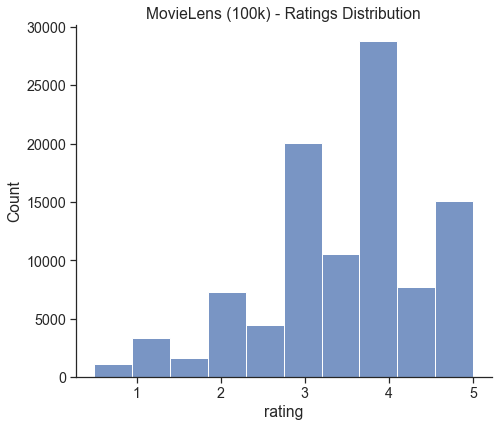

In [36]:
import seaborn as sns
import numpy as np

#make this example reproducible
np.random.seed(1)

#create histogram using 10 bins
sns.set(font_scale=1.3)
sns.set_style("ticks", {'axes.grid' : False})

# figure size in inches
sns.displot(ratings_data['rating'], bins=10, height=6, aspect=1.2).set(title='MovieLens (100k) - Ratings Distribution')

In [43]:
np.min(movies_data['year'][movies_data['year'] != 0])

1902

In [44]:
np.max(movies_data['year'])

2016

In [53]:
movies_data.head(10)

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
5,6,Heat (1995),Action|Crime|Thriller,1995
6,7,Sabrina (1995),Comedy|Romance,1995
7,8,Tom and Huck (1995),Adventure|Children,1995
8,9,Sudden Death (1995),Action,1995
9,10,GoldenEye (1995),Action|Adventure|Thriller,1995


([<matplotlib.axis.XTick at 0x7fa26a8d5978>,
 [Text(1880.0, 0, '1880'),
  Text(1900.0, 0, '1900'),
  Text(1920.0, 0, '1920'),
  Text(1940.0, 0, '1940'),
  Text(1960.0, 0, '1960'),
  Text(1980.0, 0, '1980'),
  Text(2000.0, 0, '2000'),
  Text(2020.0, 0, '2020'),
  Text(2040.0, 0, '2040'),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

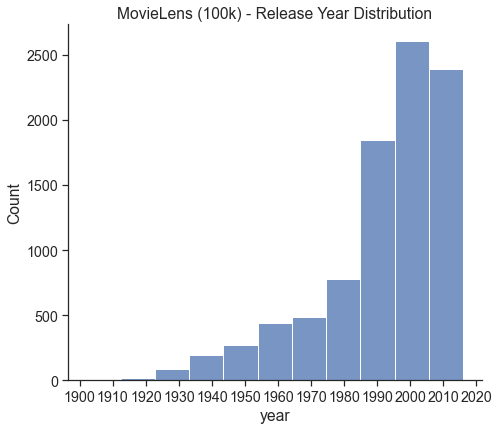

In [52]:
# figure size in inches
import matplotlib.pyplot as plt

sns.displot(movies_data['year'][movies_data['year'] != 0], bins=11, height=6, aspect=1.2).set(title='MovieLens (100k) - Release Year Distribution')

plt.xticks(np.arange(1900,2030,10))


In [5]:
ratings_data.head(10)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [8]:
print(ratings_data.head(10).to_markdown())

|    |   userId |   movieId |   rating |   timestamp |
|---:|---------:|----------:|---------:|------------:|
|  0 |        1 |        31 |      2.5 | 1.26076e+09 |
|  1 |        1 |      1029 |      3   | 1.26076e+09 |
|  2 |        1 |      1061 |      3   | 1.26076e+09 |
|  3 |        1 |      1129 |      2   | 1.26076e+09 |
|  4 |        1 |      1172 |      4   | 1.26076e+09 |
|  5 |        1 |      1263 |      2   | 1.26076e+09 |
|  6 |        1 |      1287 |      2   | 1.26076e+09 |
|  7 |        1 |      1293 |      2   | 1.26076e+09 |
|  8 |        1 |      1339 |      3.5 | 1.26076e+09 |
|  9 |        1 |      1343 |      2   | 1.26076e+09 |


In [28]:
movies_data.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [9]:
print(movies_data.head(10).to_markdown())

|    |   movieId | title                              | genres                                      |
|---:|----------:|:-----------------------------------|:--------------------------------------------|
|  0 |         1 | Toy Story (1995)                   | Adventure|Animation|Children|Comedy|Fantasy |
|  1 |         2 | Jumanji (1995)                     | Adventure|Children|Fantasy                  |
|  2 |         3 | Grumpier Old Men (1995)            | Comedy|Romance                              |
|  3 |         4 | Waiting to Exhale (1995)           | Comedy|Drama|Romance                        |
|  4 |         5 | Father of the Bride Part II (1995) | Comedy                                      |
|  5 |         6 | Heat (1995)                        | Action|Crime|Thriller                       |
|  6 |         7 | Sabrina (1995)                     | Comedy|Romance                              |
|  7 |         8 | Tom and Huck (1995)                | Adventure|Children        

In [249]:
links_data.head(10)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
5,6,113277,949.0
6,7,114319,11860.0
7,8,112302,45325.0
8,9,114576,9091.0
9,10,113189,710.0


In [10]:
print(links_data.head(10).to_markdown())

|    |   movieId |   imdbId |   tmdbId |
|---:|----------:|---------:|---------:|
|  0 |         1 |   114709 |      862 |
|  1 |         2 |   113497 |     8844 |
|  2 |         3 |   113228 |    15602 |
|  3 |         4 |   114885 |    31357 |
|  4 |         5 |   113041 |    11862 |
|  5 |         6 |   113277 |      949 |
|  6 |         7 |   114319 |    11860 |
|  7 |         8 |   112302 |    45325 |
|  8 |         9 |   114576 |     9091 |
|  9 |        10 |   113189 |      710 |


In [251]:
tags_data.head(10)

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765
5,15,35957,short,1141391873
6,15,37729,dull story,1141391806
7,15,45950,powerpoint,1169616291
8,15,100365,activist,1425876220
9,15,100365,documentary,1425876220


In [13]:
print(tags_data.head(10).to_markdown())

|    |   userId |   movieId | tag                     |   timestamp |
|---:|---------:|----------:|:------------------------|------------:|
|  0 |       15 |       339 | sandra 'boring' bullock |  1138537770 |
|  1 |       15 |      1955 | dentist                 |  1193435061 |
|  2 |       15 |      7478 | Cambodia                |  1170560997 |
|  3 |       15 |     32892 | Russian                 |  1170626366 |
|  4 |       15 |     34162 | forgettable             |  1141391765 |
|  5 |       15 |     35957 | short                   |  1141391873 |
|  6 |       15 |     37729 | dull story              |  1141391806 |
|  7 |       15 |     45950 | powerpoint              |  1169616291 |
|  8 |       15 |    100365 | activist                |  1425876220 |
|  9 |       15 |    100365 | documentary             |  1425876220 |


In [23]:
rating_count_per_movie = ratings_data[['movieId','rating']].groupby('movieId', as_index=False)\
                        .agg({'rating' : {'mean','count'}})
rating_count_per_movie.columns = rating_count_per_movie.columns.droplevel(0)
rating_count_per_movie.columns = ['movieId','rating_mean','rating_count']
rating_count_per_movie

rating_count_per_movie = pd.merge(movies_data, rating_count_per_movie, how='inner', left_on = ['movieId'], right_on = ['movieId'], right_index = False)
rating_count_per_movie.sort_values(by=['rating_count'], ascending=False).head(100)

,movieId,title,genres,rating_mean,rating_count
321,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.054252,341
266,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.256173,324
284,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.487138,311
525,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.138158,304
232,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.221649,291
427,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,3.706204,274
2062,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.183398,259
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.872470,247
472,527,Schindler's List (1993),Drama|War,4.303279,244
522,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,4.006329,237


In [106]:
rating_count_per_movie[rating_count_per_movie['title'].str.contains('Nightmare Before Christmas, The')].head(10)

,movieId,title,genres,rating_mean,rating_count,year
494,551,"Nightmare Before Christmas, The (1993)",Animation|Children|Fantasy|Musical,3.65,90,1993


In [38]:
rating_count_per_movie['year'] = pd.to_numeric(rating_count_per_movie['title'].str[-6::].str.replace("(",'').str.replace(")",'').str.replace("-",''), errors='coerce').fillna(0).astype('int')
rating_count_per_movie.head()

,movieId,title,genres,rating_mean,rating_count,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.872470,247,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.401869,107,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,3.161017,59,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.384615,13,1995
4,5,Father of the Bride Part II (1995),Comedy,3.267857,56,1995


In [103]:
rating_count_per_movie[(rating_count_per_movie['year'] >= 2010) &\
                       (rating_count_per_movie['rating_count'] > 30)]\
.sort_values(by=['rating_mean'], ascending=False).head(5).reset_index(drop=True)


,movieId,title,genres,rating_mean,rating_count,year
0,88125,Harry Potter and the Deathly Hallows: Part 2 (...,Action|Adventure|Drama|Fantasy|Mystery|IMAX,4.220588,34,2011
1,76093,How to Train Your Dragon (2010),Adventure|Animation|Children|Fantasy|IMAX,4.151515,33,2010
2,109487,Interstellar (2014),Sci-Fi|IMAX,4.151163,43,2014
3,116797,The Imitation Game (2014),Drama|Thriller|War,4.109375,32,2014
4,78499,Toy Story 3 (2010),Adventure|Animation|Children|Comedy|Fantasy|IMAX,4.071429,42,2010


In [104]:
rating_count_per_movie[(rating_count_per_movie['year'] >= 2000) &\
                       (rating_count_per_movie['year'] < 2010) &\
                       (rating_count_per_movie['rating_count'] > 30)]\
.sort_values(by=['rating_mean'], ascending=False).head(5).reset_index(drop=True)


,movieId,title,genres,rating_mean,rating_count,year
0,6016,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller,4.297101,69,2002
1,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.235537,121,2008
2,4226,Memento (2000),Mystery|Thriller,4.227273,132,2000
3,48516,"Departed, The (2006)",Crime|Drama|Thriller,4.202381,84,2006
4,4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,4.182500,200,2001


In [105]:
rating_count_per_movie[(rating_count_per_movie['year'] >= 1990) &\
                       (rating_count_per_movie['year'] < 2000) &\
                       (rating_count_per_movie['rating_count'] > 30)]\
.sort_values(by=['rating_mean'], ascending=False).head(5).reset_index(drop=True)


,movieId,title,genres,rating_mean,rating_count,year
0,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.487138,311,1994
1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.370647,201,1995
2,527,Schindler's List (1993),Drama|War,4.303279,244,1993
3,608,Fargo (1996),Comedy|Crime|Drama|Thriller,4.256696,224,1996
4,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.256173,324,1994


In [98]:
rating_count_per_movie[(rating_count_per_movie['genres'].str.contains('Action')) & \
                       (rating_count_per_movie['rating_count'] > 100) & \
                       (rating_count_per_movie['year'] >= 1990)] \
.sort_values(by=['rating_mean'], ascending=False).head(5).reset_index(drop=True)

,movieId,title,genres,rating_mean,rating_count,year
0,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.235537,121,2008
1,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.183398,259,1999
2,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.178218,202,1999
3,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,4.127841,176,2003
4,293,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller,4.071970,132,1994


In [99]:
rating_count_per_movie[(rating_count_per_movie['genres'].str.contains('Comedy')) & \
                       (~rating_count_per_movie['genres'].str.contains('Action')) & \
                       (rating_count_per_movie['rating_count'] > 100) & \
                       (rating_count_per_movie['year'] >= 1990)] \
.sort_values(by=['rating_mean'], ascending=False).head(5).reset_index(drop=True)


,movieId,title,genres,rating_mean,rating_count,year
0,608,Fargo (1996),Comedy|Crime|Drama|Thriller,4.256696,224,1996
1,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.256173,324,1994
2,778,Trainspotting (1996),Comedy|Crime|Drama,4.141129,124,1996
3,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance,4.096000,125,2001
4,356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.054252,341,1994


In [100]:
rating_count_per_movie[(rating_count_per_movie['genres'].str.contains('Romance')) & \
                       (~rating_count_per_movie['genres'].str.contains('Action')) & \
                       (~rating_count_per_movie['genres'].str.contains('Comedy')) & \
                       (rating_count_per_movie['rating_count'] > 100) & \
                       (rating_count_per_movie['year'] >= 1990)] \
.sort_values(by=['rating_mean'], ascending=False).head(5).reset_index(drop=True)

,movieId,title,genres,rating_mean,rating_count,year
0,2858,American Beauty (1999),Drama|Romance,4.236364,220,1999
1,1704,Good Will Hunting (1997),Drama|Romance,4.140127,157,1997
2,7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,4.122642,106,2004
3,4995,"Beautiful Mind, A (2001)",Drama|Romance,3.951754,114,2001
4,595,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX,3.750000,176,1991


In [24]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
rating_count_per_movie[rating_count_per_movie['rating_count'] > 75].sort_values(by=['rating_mean'], ascending=False).head(10)


,movieId,title,genres,rating_mean,rating_count
695,858,"Godfather, The (1972)",Crime|Drama,4.487500,200
284,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.487138,311
977,1221,"Godfather: Part II, The (1974)",Crime|Drama,4.385185,135
48,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,4.370647,201
1006,1252,Chinatown (1974),Crime|Film-Noir|Mystery|Thriller,4.335526,76
725,904,Rear Window (1954),Mystery|Thriller,4.315217,92
472,527,Schindler's List (1993),Drama|War,4.303279,244
729,908,North by Northwest (1959),Action|Adventure|Mystery|Romance|Thriller,4.270115,87
951,1193,One Flew Over the Cuckoo's Nest (1975),Drama,4.256944,144
535,608,Fargo (1996),Comedy|Crime|Drama|Thriller,4.256696,224


In [19]:
user_id = 410
user_data = ratings_data[['userId','movieId','rating']][ratings_data['userId'] == user_id]
user_data

user_data = pd.merge(user_data, rating_count_per_movie, how='inner', left_on = ['movieId'], right_on = ['movieId'], right_index = False)
user_data.sort_values(by=['rating','rating_mean'], ascending=[False,False]).reset_index(drop=True).head(10)


,userId,movieId,rating,title,genres,rating_mean,rating_count
0,410,318,5.0,"Shawshank Redemption, The (1994)",Crime|Drama,4.487138,311
1,410,1198,5.0,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,4.193182,220
2,410,2571,5.0,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.183398,259
3,410,4993,5.0,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,4.182500,200
4,410,5952,5.0,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,4.061170,188
5,410,356,5.0,Forrest Gump (1994),Comedy|Drama|Romance|War,4.054252,341
6,410,1270,5.0,Back to the Future (1985),Adventure|Comedy|Sci-Fi,4.015487,226
7,410,110,5.0,Braveheart (1995),Action|Drama|War,3.945175,228
8,410,5418,5.0,"Bourne Identity, The (2002)",Action|Mystery|Thriller,3.880000,100
9,410,1,5.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.872470,247


In [20]:
print(user_data.head(10).to_markdown())

|    |   userId |   movieId |   rating | title                                     | genres                                      |   rating_mean |   rating_count |
|---:|---------:|----------:|---------:|:------------------------------------------|:--------------------------------------------|--------------:|---------------:|
|  0 |      410 |         1 |      5   | Toy Story (1995)                          | Adventure|Animation|Children|Comedy|Fantasy |       3.87247 |            247 |
|  1 |      410 |        32 |      4.5 | Twelve Monkeys (a.k.a. 12 Monkeys) (1995) | Mystery|Sci-Fi|Thriller                     |       3.92347 |            196 |
|  2 |      410 |        34 |      1.5 | Babe (1995)                               | Children|Drama                              |       3.60135 |            148 |
|  3 |      410 |       110 |      5   | Braveheart (1995)                         | Action|Drama|War                            |       3.94518 |            228 |
|  4 |      410 

In [119]:
275

475

410

600 - Animated Movies

275

In [17]:
def LoadMovieLensData():
    ml = MovieLens()
    
    print("Loading movie ratings...")
    data = ml.loadMovieLensLatestSmall()
    
    user_id = 85
    print("\nUser Ratings for : ", user_id)
    user = getUserRatings(user_id)
    
    print("\nComputing movie popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, user, rankings)

In [18]:
np.random.seed(0)

# Load up common data set for the recommender algorithms
(ml, evaluationData, sample_user, rankings) = LoadMovieLensData()

Loading movie ratings...

Computing movie popularity ranks so we can measure novelty later...


In [21]:
evaluationData

In [ ]:
from surprise import Dataset
import pandas as pd
data = Dataset.load_builtin('ml-100k')
pd.DataFrame(data.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])